## <span style="color:navy"> Esercitazione 7</span>

## <span style="color:teal"> Esercizio 7.1</span>



Nelle simulazioni precedenti abbiamo introdotto un raggio di cut-off ($r_c$) oltre il quale si troncano i contributi di ogni particella. Per stimare correttamente l'energia potenziale e la pressione includendo i contributi oltre $r_c$, ho applicato le seguenti correzioni di coda nel codice (in unità LJ):

$$
\frac{\langle U \rangle_{\text{tail}}}{N} = 8\pi\rho \left( \frac{1}{9r_c^9} - \frac{1}{3r_c^3} \right)
$$

$$
\frac{\langle P \rangle_{\text{tail}}}{3N} = 32\pi\rho \left( \frac{1}{9r_c^9} - \frac{1}{6r_c^3} \right)
$$

## <span style="color:teal"> Esercizio 7.2</span>

In questo esercizio ho utilizzato il codice NSL_SIMULATOR per analizzare le fluttuazioni dell'energia potenziale per particella $U/N$, durante simulazioni di Monte Carlo (MC) nell'ensemble canonico (NVT) e Molecular Dynamics (MD) nel microcanonico (NVE), entrambe nella fase liquida ($\rho^* = 0.8$, $T^* = 1.1$) con $r^\star_c = 2.5$. 

Per MC ho fissato $dt=0.1$ in modo da avere un'accettanza del 50%, mentre per MD ho usato $dt^\star=0.001$ come suggerito dalla consegna.

Lo scopo dell'esercizio è individuare la lunghezza ottimale di ciascun blocco, questa procedura è fondamentale per ottenere stime affidabili delle incertezze delle quantità termodinamiche.
Per entrambi i metodi ho eseguito una fase di equilibriazione iniziale. Una volta raggiunto l’equilibrio, ho effettuato la raccolta dati su **$M = 5\times10^5$** passi e ho preso per ogni passo il valore dell'energia potenziale per particella $U/N$ e la sua incertezza.


Utilizzando i valori istantanei di $U/N$ (cioè raccolti ogni singolo passo), ho calcolato la funzione di autocorrelazione per stimare il tempo di correlazione caratteristico del sistema, ovvero il numero di passi oltre il quale i dati diventano statisticamente indipendenti. Questo è servito a valutare la dimensione minima dei blocchi da usare nella tecnica del data blocking, infatti i blocchi devono essere almeno una decina di volte più grossi dei tempi di correlazione.


Ho poi applicato il data blocking per stimare l'incertezza statistica su $\langle U/N \rangle$ come funzione della dimensione del blocco $L$. Ho variato $L$ da $10$ fino a $5000$ e calcolato per ciascun caso la deviazione standard tra i blocchi.

Ho ripetuto l’intera analisi sia per la simulazione MC che per quella MD, confrontando l’efficienza statistica dei due metodi.


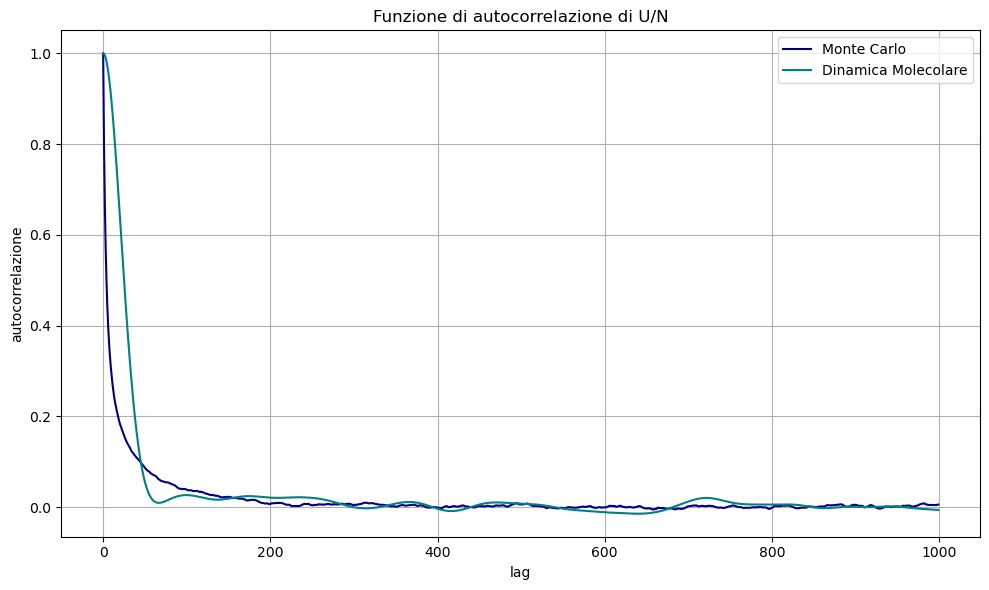

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

t_max = 500_000

# Carico i dati dal file
data_MC = np.loadtxt("Simulazioni_MC/OUTPUT_7.2/potential_energy.dat")
data_MD = np.loadtxt("Simulazioni_MD/OUTPUT_7.2/potential_energy.dat")

# importo in un array il numero di step che faccio e in un array il valore dell'energia potenziale a ogni valore di step
t = data_MC[:, 0]   # Prima colonna: contiene il numero di blocchi
U_MC = data_MC[:, 1]   # Seconda colonna: contiene il valore istantaneo di energia potenziale
U_MD = data_MD[:, 1]

autocorrelation_MC = []
autocorrelation_MD = []
t_calcolati = []

for i in range(0, 1000):
    a_MC = a_MD = b_MC = b_MD = c_MC = c_MD = d_MC = d_MD = e_MC = e_MD = 0.0
    for j in range(t_max - i):
        a_MC += U_MC[j] * U_MC[j+i]
        a_MD += U_MD[j] * U_MD[j+i]
        b_MC += U_MC[j]
        b_MD += U_MD[j]
        c_MC += U_MC[j+i]
        c_MD += U_MD[j+i]
    for k in range(t_max):
        d_MC += U_MC[k] * U_MC[k]
        d_MD += U_MD[k] * U_MD[k]
        e_MC += U_MC[k]
        e_MD += U_MD[k]

    denom_MC = (1./t_max) * d_MC - ((1./t_max) * e_MC) ** 2
    denom_MD = (1./t_max) * d_MD - ((1./t_max) * e_MD) ** 2

    autocorrelation_MC.append(((1. / (t_max - i)) * a_MC - (1. / (t_max - i)) * b_MC * (1. / (t_max - i)) * c_MC) / denom_MC)
    autocorrelation_MD.append(((1. / (t_max - i)) * a_MD - (1. / (t_max - i)) * b_MD * (1. / (t_max - i)) * c_MD) / denom_MD)
    t_calcolati.append(i)

# Plot sovrapposto
plt.figure(figsize=(10, 6))
plt.plot(t_calcolati, autocorrelation_MC, color='navy', label='Monte Carlo')
plt.plot(t_calcolati, autocorrelation_MD, color='teal', label='Dinamica Molecolare')

plt.title("Funzione di autocorrelazione di U/N")
plt.xlabel("lag")
plt.ylabel("autocorrelazione")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


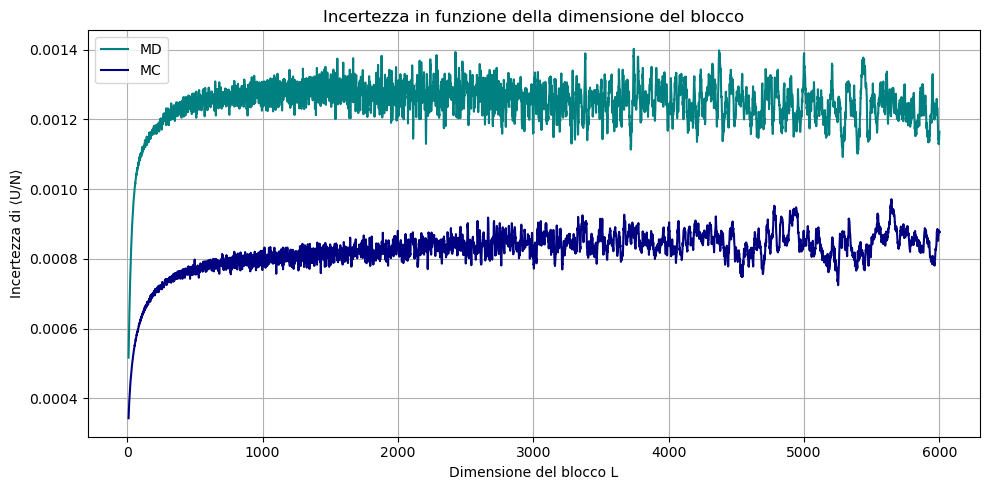

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def media_blocchi (data, L): #funzione media_blocchi prende array dati e dimensione blocchi
    M=len(data)#numero di dati
    N=M//L#numero di blocchi
    if N<2: #non ho statistica
        return None, None
    blocks = data[:N*L].reshape(N, L) #mi prende i dati e li organizza in matrice con ogni riga un blocco
    block_means = np.mean(blocks, axis=1) #calcola media di ogni blocco
    avg = np.mean(block_means) #calcola media dei blocchi
    std_err = np.std(block_means, ddof=1) / np.sqrt(N) #errore
    return avg, std_err

# dati
data_md = np.loadtxt("Simulazioni_MD/OUTPUT_7.2/potential_energy.dat")[:, 1] 
data_mc = np.loadtxt("Simulazioni_MC/OUTPUT_7.2/potential_energy.dat")[:, 1] 
M = len(data_md) 

 
block_sizes = np.arange(10,6001,1) #vettori di valori di L logaritmici 

errors_md = []
errors_mc = []
valid_L = []

for L in block_sizes: 
    _, err_md = media_blocchi(data_md, L)
    _, err_mc = media_blocchi(data_mc, L)
    if err_md is not None:
        errors_md.append(err_md)
        errors_mc.append(err_mc)
        valid_L.append(L)

#plot
plt.figure(figsize=(10, 5))
plt.plot(valid_L, errors_md, label="MD", color='teal')
plt.plot(valid_L, errors_mc, label="MC", color='navy')
plt.xlabel("Dimensione del blocco L")
plt.ylabel("Incertezza di ⟨U/N⟩")

plt.title("Incertezza in funzione della dimensione del blocco")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Nel primo grafico è rappresentata la funzione di autocorrelazione normalizzata dell'energia potenziale per particella, $U/N$, ottenuta sia da simulazioni Monte Carlo (MC) che Molecular Dynamics (MD). Entrambe le curve mostrano un decadimento entro circa 200/300 passi: ciò indica che, oltre questo lag, le configurazioni generate diventano statisticamente indipendenti.

Confrontando le due tecniche:
- L’autocorrelazione decade più rapidamente nel caso MC nel primo tratto.
- La curva MD, invece, mostra una correlazione più persistente all'inizio, ma si annulla intorno a valori simili al MC.

Nella seconda figura viene riportata l’incertezza statistica stimata su $\langle U/N \rangle$ in funzione della dimensione del blocco $L$.
- Per valori piccoli di $L$ (inferiori al tempo di autocorrelazione), l’errore è sottostimato, perché i blocchi contengono dati correlati.
- Al crescere di $L$, l’errore stimato aumenta e si stabilizza su un plateau, raggiunto quando i blocchi diventano sufficientemente grandi da essere mutuamente indipendenti.

Questa regione piatta rappresenta l’incertezza corretta, che tiene conto delle fluttuazioni reali del sistema.

In entrambi i casi, una dimensione del blocco $L =3000$ è sufficiente per garantire l’indipendenza statistica dei blocchi.

## <span style="color:teal"> Esercizio 7.3</span>

## Implementazione della funzione di distribuzione radiale (g(r))
In questo esercizio ho implementato nel codice il calcolo della funzione di distribuzione radiale (GOFR). Questa funzione misura la probabilità relativa di trovare una particella a distanza $r$ da una particella di riferimento, normalizzata rispetto a un gas ideale con la stessa densità.

Per un fluido omogeneo, la GOFR è definita come:

$$
g(r) = \frac{1}{\rho N \Delta V(r)} \left\langle \sum_{i \neq j=1}^{N} \delta(r - |\vec{r}_i - \vec{r}_j|) \right\rangle
$$
  dove $\Delta V(r) = \frac{4\pi}{3} [(r + dr)^3 - r^3]$ è il volume del guscio sferico di spessore $dr$

## <span style="color:teal"> Esercizio 7.4</span>

In questo esercizio ho utilizzato il codice appena aggiornato per confrontare i risultati che si ottengono dalla simulazione di uno stesso sistema (Argon liquido: $\rho^\star = 0.8$, $T^\star = 1.1$, $r_c = 2.5$) con due tipi di simulazione diverse: Monte Carlo nell’ensemble canonico (NVT) e la Dinamica Molecolare nell’ensemble microcanonico (NVE).


Per ognuno dei due approcci ho nuovamente equilibrato il sistema con 5000 blocchi composti da un singolo step per poi eseguire una simulazione da 30 blocchi da 3000 step ciascuno.
I grafici sottostanti rappresentano i valori ottenuti per la pressione e per l'energia potenziale per particella ottenuti con le rispettive incertezze e la distribuzione di $g(r)$ ottenuta con entrambi i metodi.

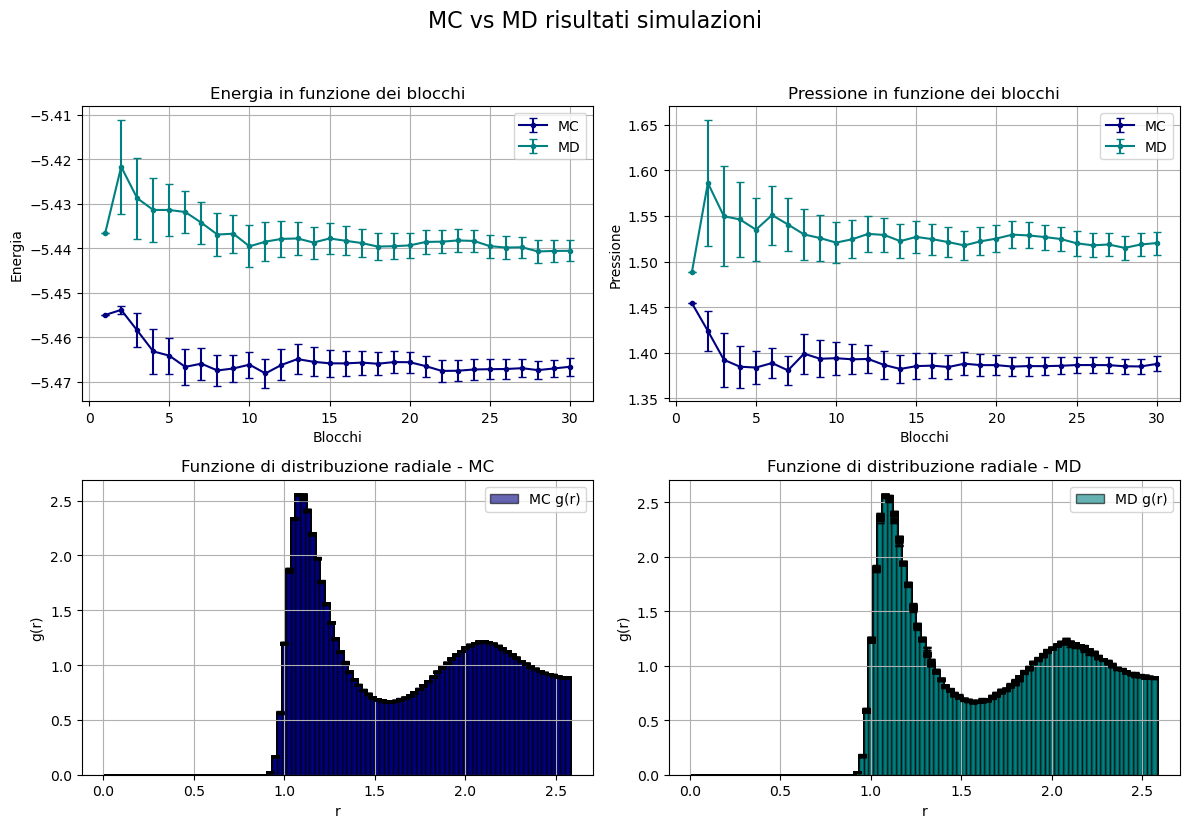

In [20]:
import numpy as np
import matplotlib.pyplot as plt


# Define some nicer colors
colors = plt.get_cmap('tab10').colors
set2 = plt.get_cmap('Set2').colors

# carico dati MC
N_MC, _, energyMC, errorenergyMC = np.loadtxt("Simulazioni_MC/OUTPUT_7.4/potential_energy.dat", usecols=(0, 1, 2, 3), unpack=True)
_, _, pressureMC, errorpressureMC = np.loadtxt("Simulazioni_MC/OUTPUT_7.4/pressure.dat", usecols=(0, 1, 2, 3), unpack=True)
binsMC, _, gofrMC, errorgofrMC = np.loadtxt("Simulazioni_MC/OUTPUT_7.4/gofr.dat", usecols=(0, 1, 2, 3), unpack=True)

# carico dati MD
N_MD, _, energyMD, errorenergyMD = np.loadtxt("Simulazioni_MD/OUTPUT_7.4/potential_energy.dat", usecols=(0, 1, 2, 3), unpack=True)
_, _, pressureMD, errorpressureMD = np.loadtxt("Simulazioni_MD/OUTPUT_7.4/pressure.dat", usecols=(0, 1, 2, 3), unpack=True)
binsMD, _, gofrMD, errorgofrMD = np.loadtxt("Simulazioni_MD/OUTPUT_7.4/gofr.dat", usecols=(0, 1, 2, 3), unpack=True)

# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MC vs MD risultati simulazioni", fontsize=16, y=1.03)

# energia
axs[0, 0].errorbar(N_MC, energyMC, yerr=errorenergyMC, label='MC', fmt='o-', markersize=3, color='navy', capsize=3)
axs[0, 0].errorbar(N_MD, energyMD, yerr=errorenergyMD, label='MD', fmt='o-', markersize=3, color='teal', capsize=3)
axs[0, 0].set_xlabel("Blocchi")
axs[0, 0].set_ylabel("Energia")
axs[0, 0].set_title("Energia in funzione dei blocchi")
axs[0, 0].legend()
axs[0, 0].grid(True)

# pressione
axs[0, 1].errorbar(N_MC, pressureMC, yerr=errorpressureMC, label='MC', fmt='o-', markersize=3, color='navy', capsize=3)
axs[0, 1].errorbar(N_MD, pressureMD, yerr=errorpressureMD, label='MD', fmt='o-', markersize=3, color='teal', capsize=3)
axs[0, 1].set_xlabel("Blocchi")
axs[0, 1].set_ylabel("Pressione")
axs[0, 1].set_title("Pressione in funzione dei blocchi")
axs[0, 1].legend()
axs[0, 1].grid(True)

# gofr_MC
axs[1, 0].bar(binsMC, gofrMC, width=0.03, align='center', alpha=0.6, color='navy', edgecolor='black', label='MC g(r)')
axs[1, 0].errorbar(binsMC, gofrMC, yerr=errorgofrMC, fmt='none', ecolor='black', capsize=3)
axs[1, 0].set_xlabel("r")
axs[1, 0].set_ylabel("g(r)")
axs[1, 0].set_title("Funzione di distribuzione radiale - MC")
axs[1, 0].legend()
axs[1, 0].grid(True)

# gofr_MD
axs[1, 1].bar(binsMD, gofrMD, width=0.03, align='center', alpha=0.6, color='teal', edgecolor='black', label='MD g(r)')
axs[1, 1].errorbar(binsMD, gofrMD, yerr=errorgofrMD, fmt='none', ecolor='black', capsize=3)
axs[1, 1].set_xlabel("r")
axs[1, 1].set_ylabel("g(r)")
axs[1, 1].set_title("Funzione di distribuzione radiale - MD")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


I valori medi mostrati nei grafici in funzione dei blocchi sono simili sia per la pressione che per l'energia potenziale per particella, ma non compatibili statisticamente.
Questa leggera discrepanza può essere attribuita al fatto che Monte Carlo e Molecular Dynamics campionano rigorosamente lo stesso insieme statistico solo nel limite termodinamico (cioè per $N \to \infty$). Poiché in queste simulazioni viene utilizzato un numero finito e relativamente piccolo di particelle (108), differenze minori tra i due approcci sono giustificate.

Le funzioni di distribuzione radiale mostrate nei pannelli inferiori, invece, risultano praticamente identiche.
